In [1]:
!pip install datasets

In [2]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm

In [3]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
train_data, test_data = datasets.load_dataset("imdb", split=["train", "test"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
train_data , test_data

(Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }))

In [6]:
train_data.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

###TOKENIZATION


In [7]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

In [8]:
def tokenize_example(example , tokenizer , max_length):
  tokens = tokenizer(example['text'])[:max_length]
  return {"tokens": tokens}

In [9]:
max_length = 256
train_data = train_data.map(
    tokenize_example , fn_kwargs= {"tokenizer" : tokenizer , "max_length" : max_length}
)

test_data = test_data.map(
    tokenize_example , fn_kwargs = {"tokenizer": tokenizer ,"max_length": max_length}
)

In [10]:
train_data

Dataset({
    features: ['text', 'label', 'tokens'],
    num_rows: 25000
})

###Creating Validation Data


In [11]:
test_size = 0.20
train_valid_data = train_data.train_test_split(test_size  = test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]


###Creating Vocabulary


In [12]:
min_freq = 4
special_tokens = ["<unk>" , "<pad>" , "<cls>" , "<sep>"]

vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["tokens"],
    min_freq = min_freq,
    specials = special_tokens
)

In [13]:
vocab.get_itos()[:15]

['<unk>',
 '<pad>',
 '<cls>',
 '<sep>',
 'the',
 '.',
 ',',
 'a',
 'and',
 'of',
 'to',
 "'",
 'is',
 'it',
 'i']

In [14]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]
cls_index = vocab["<cls>"]
sep_index = vocab["<sep>"]


In [15]:
#if some tokens are not present in vocab it will give index

vocab.set_default_index(cls_index)


In [16]:
vocab["somw"]

2

In [17]:
vocab.lookup_indices(["hello", "world", "some_token", "<pad>"])

[5459, 187, 2, 1]

###Numericalizing Data

In [18]:
def numericalize_data(example , vocab):
  ids = vocab.lookup_indices(example["tokens"])
  return {"ids" : ids}

In [19]:
train_data = train_data.map(numericalize_data , fn_kwargs= {"vocab" : vocab})
valid_data = valid_data.map(numericalize_data , fn_kwargs = {"vocab" : vocab})
test_data = test_data.map(numericalize_data , fn_kwargs = {"vocab" : vocab})

In [20]:
# transforming the ids and label from integers into PyTorch tensors, which we do using the with_format method

train_data = train_data.with_format(type = "torch" , columns= ["ids" , "label"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

In [21]:
train_data[0]["ids"][:10]

tensor([ 118,  718,   14,   11,  141,  302, 2863,   17,   96,   84])

In [22]:
train_data[0].keys()

dict_keys(['label', 'ids'])

In [23]:
def get_Collate_fn(pad_index):
  def collate_fn(batch):
    batch_ids = [i["ids"] for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(
        batch_ids , padding_value = pad_index , batch_first= True
    )

    batch_label = [i["label"] for i in batch]
    batch_label = torch.stack(batch_label)
    batch = {"ids": batch_ids , "label": batch_label}
    return batch

  return collate_fn

In [24]:
def get_data_loader(dataset , batch_size , pad_index , shuffle = False):
  collate_fn = get_Collate_fn(pad_index)
  data_loader = torch.utils.data.DataLoader(
      dataset = dataset,
      batch_size = batch_size ,
      collate_fn = collate_fn,
      shuffle = shuffle
  )
  return data_loader

In [25]:
batch_size = 512

train_data_loader = get_data_loader(train_data , batch_size , pad_index , shuffle = True)
valid_data_loader = get_data_loader(valid_data , batch_size , pad_index)
test_data_loader = get_data_loader(test_data, batch_size , pad_index)

###Building Model


In [26]:
class NBoW(nn.Module):
  def __init__(self , vocab_size , embedding_dim , output_dim , pad_index):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim , padding_idx = pad_index)
    self.fc = nn.Linear(embedding_dim , output_dim)

  def forward(self , ids):
    embebbed = self.embedding(ids)
    pooled = embebbed.mean(dim = 1)
    predicted = self.fc(pooled)

    return predicted

In [27]:
vocab_size = len(vocab)
embedding_dim  = 300

output_dim = len(train_data.unique("label"))

model = NBoW(vocab_size , embedding_dim , output_dim , pad_index)

In [28]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model): ,} trainable parameters")


The model has  7,651,202 trainable parameters


In [29]:
vectors = torchtext.vocab.GloVe()

In [30]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

In [31]:
pretrained_embedding.shape

torch.Size([25502, 300])

In [32]:
model.embedding.weight

Parameter containing:
tensor([[-0.1117, -0.4966,  0.1631,  ..., -0.5592, -0.4480, -0.6476],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.7882, -1.6625, -0.7064,  ..., -1.5841, -0.3711, -1.2338],
        ...,
        [ 0.5408, -2.4592,  1.2055,  ...,  1.5511,  0.3961,  1.3328],
        [-0.3017,  0.9250,  1.2910,  ...,  1.3969,  0.9476,  0.5435],
        [ 0.5138, -0.4632, -0.2360,  ...,  1.1965,  0.6821, -0.1939]],
       requires_grad=True)

In [33]:
pretrained_embedding

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1018,  0.4327,  0.2571,  ...,  0.3643,  0.3099,  0.1195],
        [ 1.1741, -0.4386,  0.3310,  ...,  0.3193, -0.2292, -0.0887]])

In [34]:
model.embedding.weight.data = pretrained_embedding

In [35]:
model.embedding.weight

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1018,  0.4327,  0.2571,  ...,  0.3643,  0.3099,  0.1195],
        [ 1.1741, -0.4386,  0.3310,  ...,  0.3193, -0.2292, -0.0887]],
       requires_grad=True)

In [36]:
optimizer = optim.Adam(model.parameters())

In [37]:
criterion = nn.CrossEntropyLoss()

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [39]:
model = model.to(device)
criterion = criterion.to(device)

In [40]:
def get_accuracy(prediction , label):
  batch_size , _ = prediction.shape
  predicted_classes = prediction.argmax(dim = -1)
  correct_predictions = predicted_classes.eq(label).sum()
  accuracy = correct_predictions/ batch_size
  return accuracy

In [41]:
def train(data_loader , model , criterion , optimizer , device):
  model.train()
  epoch_losses = []
  epoch_accs = []
  for batch in tqdm.tqdm(data_loader , desc = "trainning.."):
    ids = batch["ids"].to(device)
    label = batch["label"].to(device)
    prediction = model(ids)
    loss = criterion(prediction , label)
    accuracy = get_accuracy(prediction , label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_losses.append(loss.item())
    epoch_accs.append(accuracy.item())

  return np.mean(epoch_losses) , np.mean(epoch_accs)


In [42]:
def evaluate(data_loader, model , criterion,device):
  model.eval()
  epoch_losses = []
  epoch_accs= []
  with torch.no_grad():
    for batch in tqdm.tqdm(data_loader , desc = "evaluating.."):
      ids = batch["ids"].to(device)
      label = batch["label"].to(device)
      prediction = model(ids)
      loss = criterion(prediction , label)
      accuracy = get_accuracy(prediction , label)
      epoch_losses.append(loss.item())
      epoch_accs.append(accuracy.item())

  return np.mean(epoch_losses), np.mean(epoch_accs)

In [44]:
n_epochs = 15
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
  train_loss, train_acc = train(
      train_data_loader , model, criterion , optimizer , device
  )
  valid_loss , valid_acc = evaluate(valid_data_loader , model , criterion , device)
  metrics["train_losses"].append(train_loss)
  metrics["train_accuracy"].append(train_acc)
  metrics["valid_losses"].append(valid_loss)
  metrics["valid_accuracy"].append(valid_acc)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict() , "nbow.pt")

  print(f"epoch: {epoch}")
  print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
  print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")


evaluating..: 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


epoch: 0
train_loss: 0.630, train_acc: 0.737
valid_loss: 0.598, valid_acc: 0.764


evaluating..: 100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


epoch: 1
train_loss: 0.559, train_acc: 0.792
valid_loss: 0.527, valid_acc: 0.800


evaluating..: 100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


epoch: 2
train_loss: 0.485, train_acc: 0.830
valid_loss: 0.464, valid_acc: 0.827


evaluating..: 100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


epoch: 3
train_loss: 0.417, train_acc: 0.858
valid_loss: 0.413, valid_acc: 0.851


evaluating..: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


epoch: 4
train_loss: 0.367, train_acc: 0.875
valid_loss: 0.380, valid_acc: 0.859


evaluating..: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


epoch: 5
train_loss: 0.326, train_acc: 0.890
valid_loss: 0.353, valid_acc: 0.868


evaluating..: 100%|██████████| 10/10 [00:01<00:00,  6.34it/s]


epoch: 6
train_loss: 0.295, train_acc: 0.900
valid_loss: 0.334, valid_acc: 0.875


evaluating..: 100%|██████████| 10/10 [00:01<00:00,  5.63it/s]


epoch: 7
train_loss: 0.270, train_acc: 0.910
valid_loss: 0.320, valid_acc: 0.880


evaluating..: 100%|██████████| 10/10 [00:01<00:00,  6.44it/s]


epoch: 8
train_loss: 0.252, train_acc: 0.917
valid_loss: 0.310, valid_acc: 0.881


evaluating..: 100%|██████████| 10/10 [00:01<00:00,  6.08it/s]


epoch: 9
train_loss: 0.230, train_acc: 0.925
valid_loss: 0.302, valid_acc: 0.882


evaluating..: 100%|██████████| 10/10 [00:01<00:00,  5.53it/s]


epoch: 10
train_loss: 0.215, train_acc: 0.932
valid_loss: 0.296, valid_acc: 0.885


evaluating..: 100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


epoch: 11
train_loss: 0.200, train_acc: 0.937
valid_loss: 0.293, valid_acc: 0.884


evaluating..: 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]


epoch: 12
train_loss: 0.185, train_acc: 0.944
valid_loss: 0.286, valid_acc: 0.888


evaluating..: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


epoch: 13
train_loss: 0.172, train_acc: 0.949
valid_loss: 0.286, valid_acc: 0.888


evaluating..: 100%|██████████| 10/10 [00:01<00:00,  6.03it/s]


epoch: 14
train_loss: 0.164, train_acc: 0.952
valid_loss: 0.283, valid_acc: 0.889


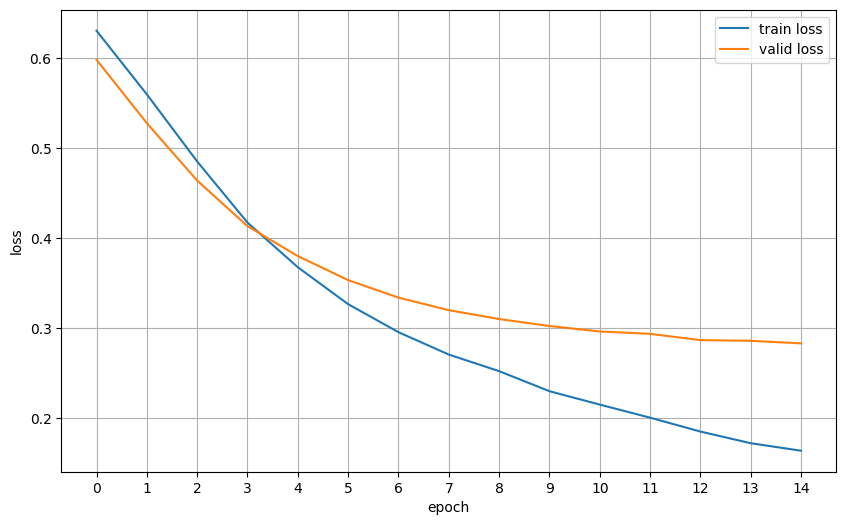

In [45]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

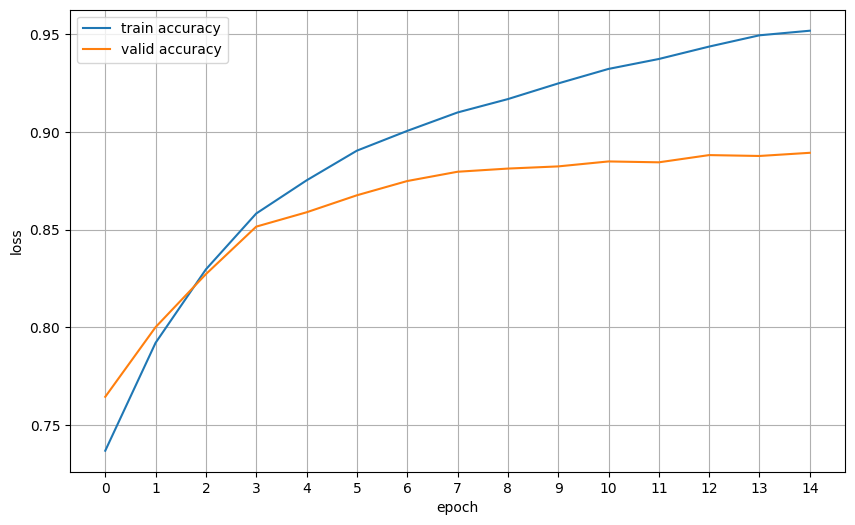

In [47]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accuracy"], label="train accuracy")
ax.plot(metrics["valid_accuracy"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()